In [6]:
#### Import section ####
from __future__ import absolute_import, division, print_function, unicode_literals

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2
import random
from glob import glob


from tqdm import tqdm #Progress bar


# To rezise images
import skimage
from skimage.transform import resize

# We will use datetime to name the tensorboard files
import datetime


print("TensorFlow version:", tf.__version__)

# GPU Configuration
# We need  CUDA 11.2 & cuDNN 8.1 for Tensorflow 2.10 and Python 3.8.20
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("Memory growth set for GPUs")
    except RuntimeError as e:
        print(e)
else:
    print("No GPUs detected")


TensorFlow version: 2.10.0
Memory growth set for GPUs


In [4]:
#### Image pre-processing ####
train_folder = "chest_xray/train/"
test_folder =  "chest_xray/test/"

# Load is True only at the first time
LOAD_FROM_IMAGES = False

def get_data(folder):
    X = []
    Y = []
    for folderName in os.listdir(folder):
        if not folderName.startswith('.'):
            if folderName in ['NORMAL']:
                label = 0
            elif folderName in ['PNEUMONIA']:
                label = 1
            for image_filename in tqdm(os.listdir(folder + folderName)):
                img_file = cv2.imread(folder + folderName + '/' + image_filename)
                if img_file is not None:
                    img_file = skimage.transform.resize(img_file, (150, 150, 3),mode='constant',anti_aliasing=True)
                    img_arr = np.asarray(img_file)
                    X.append(img_arr)
                    Y.append(label)
    X = np.asarray(X)
    Y = np.asarray(Y)
    return X,Y


if LOAD_FROM_IMAGES:
    # We load the images to the arrays (only the first time and then we change LOAD to False)
    X_train, Y_train = get_data(train_folder)
    X_test, Y_test= get_data(test_folder)
    
    # We save the arrays in files
    np.save('xtrain.npy', X_train)
    np.save('ytrain.npy', Y_train)
    np.save('xtest.npy', X_test)
    np.save('ytest.npy', Y_test)
else:
    # We load the arrays previously saved
    X_train = np.load('xtrain.npy')
    Y_train = np.load('ytrain.npy')
    X_test = np.load('xtest.npy')
    Y_test = np.load('ytest.npy')

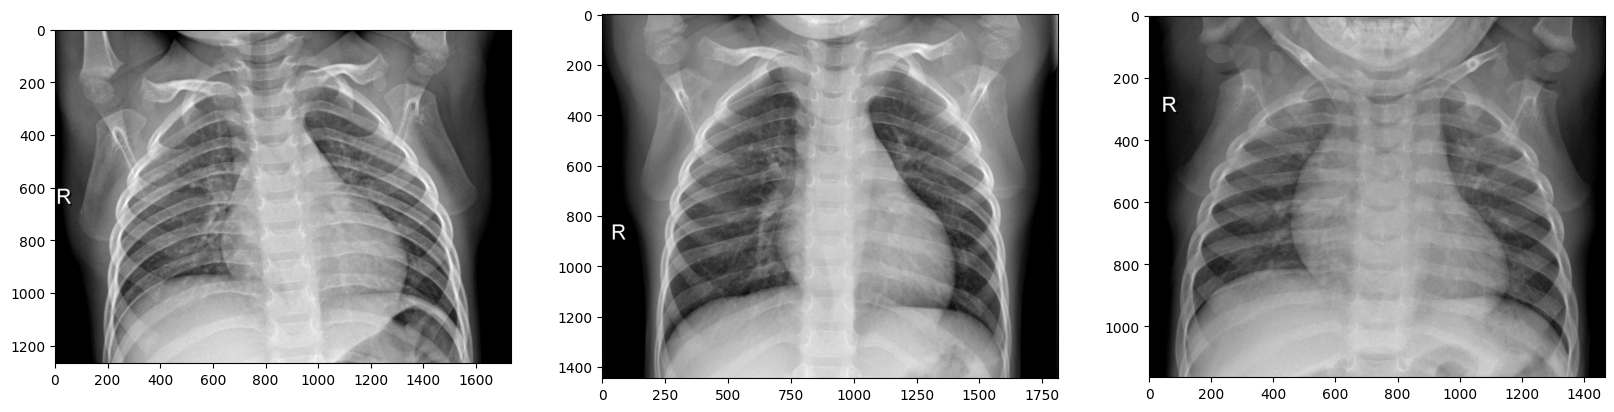

In [9]:
multipleImages = glob('chest_xray/train/NORMAL/**')
def plotThreeImages(images):
    r = random.sample(images, 3)
    plt.figure(figsize=(20,20))
    plt.subplot(131)
    plt.imshow(cv2.imread(r[0]))
    plt.subplot(132)
    plt.imshow(cv2.imread(r[1]))
    plt.subplot(133)
    plt.imshow(cv2.imread(r[2])); 
plotThreeImages(multipleImages)

In [11]:
#### Designing the model ####
# We can change the number  of filters in the convolutions
# Importar las bibliotecas necesarias de Keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout, Dense

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    Flatten(),
    Dropout(0.5),
    Dense(1, activation='sigmoid') #Sigmoid because it's a binary classification, softmax is for multiple classification
])

# Note: The Dropout layer is a mask that cancels the contribution of some neurons to the next layer, 
# it is important in the training of CNNs because it prevents overfitting of the training data.
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 64)        36928     
                                                                 
 flatten (Flatten)           (None, 73984)             0

In [12]:
# Compiling the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

log_dir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir, histogram_freq=1)


# Training the model
history= model.fit(X_train, Y_train, epochs=5, validation_data = (X_test,Y_test), callbacks=[tensorboard_callback])

Epoch 1/5
84/84 [==============================] - 13s 65ms/step - loss: 0.3672 - accuracy: 0.8292 - val_loss: 0.4288 - val_accuracy: 0.7965
Epoch 2/5
84/84 [==============================] - 4s 47ms/step - loss: 0.1715 - accuracy: 0.9336 - val_loss: 0.4630 - val_accuracy: 0.8013
Epoch 3/5
84/84 [==============================] - 4s 47ms/step - loss: 0.1645 - accuracy: 0.9340 - val_loss: 0.5199 - val_accuracy: 0.7853
Epoch 4/5
84/84 [==============================] - 4s 47ms/step - loss: 0.2141 - accuracy: 0.9176 - val_loss: 0.3225 - val_accuracy: 0.8686
Epoch 5/5
84/84 [==============================] - 4s 47ms/step - loss: 0.1180 - accuracy: 0.9523 - val_loss: 0.6447 - val_accuracy: 0.7885


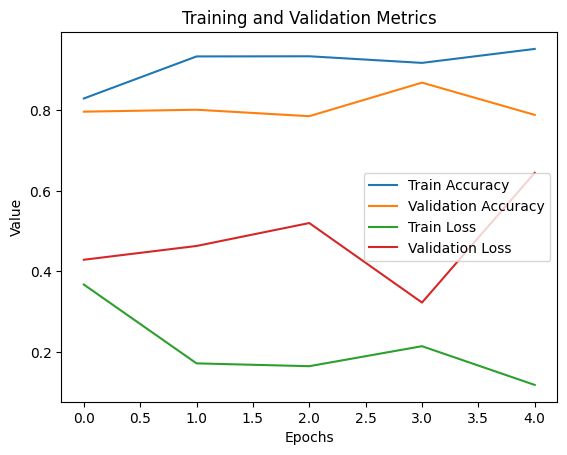

In [13]:
# Evaluating the model
train_accuracy = history.history['accuracy']
train_loss = history.history['loss']

val_accuracy = history.history['val_accuracy']
val_loss = history.history['val_loss']

plt.plot(train_accuracy, label='Train Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')

# Graphics
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')

plt.xlabel('Epochs')
plt.ylabel('Value')
plt.title('Training and Validation Metrics')
plt.legend()
plt.show()


